In [1]:
#Pre-Processing
import os
import re
import torch
import random
import itertools

#Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

# For visualising metrics
from visdom import Visdom

# For visualising gradients plot
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import copy
import math
import time

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")
print("The device found: "+str(device))

The device found: cuda


In [3]:

class VisdomLinePlotter(object):
    """Plots to Visdom"""
    
    def __init__(self, env_name='main'):
        self.viz = Visdom()
        self.env = env_name
        self.plots = {}
    def plot(self, var_name, split_name, title_name, x, y):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
                legend=[split_name],
                title=title_name,
                xlabel='Epochs',
                ylabel=var_name
            ))
        else:
            self.viz.line(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[var_name], name=split_name, update = 'append')

In [4]:
path='C:\\Users\\deepa\\Conversational Agents\\Datasets'
dataset='cornell movie-dialogs corpus'

data_folder=os.path.join(path,dataset)

print("The final data corpus folder: "+str(data_folder))

The final data corpus folder: C:\Users\deepa\Conversational Agents\Datasets\cornell movie-dialogs corpus


In [5]:
def get_lines_conversations():
    """
    Loads movie lines and conversations from the dataset.
    
    data_folder: Destination where conversations and lines are stored.
    
    movie_lines: Consist of movie lines as given by the dataset.
    movie_conversations: Consist of movie conversations as given by the dataset.
    
    """
    f=open(os.path.join(data_folder,'movie_lines.txt'),'r')
    movie_lines=f.read().splitlines()
    f.close()
    
    f=open(os.path.join(data_folder,'movie_conversations.txt'),'r')
    movie_conversations=f.read().splitlines()
    f.close()
    
    return movie_lines,movie_conversations


In [6]:
movie_lines,movie_conversations=get_lines_conversations()

print("Number of distinct lines: "+str(len(movie_lines)))
print("Number of conversations: "+str(len(movie_conversations)))
print("Average Number of lines per conversations: "+str(len(movie_lines)/len(movie_conversations)))

print(movie_lines[0])
print(movie_conversations[0])

Number of distinct lines: 304713
Number of conversations: 83097
Average Number of lines per conversations: 3.6669554857576085
L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']


In [7]:
def loadLines(movie_lines,fields):
    lines={}
    for line in movie_lines:
        values=line.split(" +++$+++ ")
        
        lineVals={}
        
#         print("values"+str(len(values)))
#         print("fields"+str(len(fields)))
              
        for i,field in enumerate(fields):
            lineVals[field]=values[i]
        
        lines[lineVals['lineID']]=lineVals
    
    return lines

def loadConversations(movie_conversations,lines,fields):
    conversations=[]
    
    for convo in movie_conversations:
        values=convo.split(" +++$+++ ")
        conVals={}
       
        for i,field in enumerate(fields):
            conVals[field]=values[i]
        
        lineIDs=eval(conVals["utteranceIDs"])
        
        conVals["lines"]=[]
        
        for lineID in lineIDs:
            conVals["lines"].append(lines[lineID])
        conversations.append(conVals)
        
    return conversations

def sentencePairs(conversations):
    qr_pairs=[]
    
    for conversation in conversations:
        for i in range(len(conversation["lines"])-1):
            query=conversation["lines"][i]["text"].strip()
            response=conversation["lines"][i+1]["text"].strip()
            
            if query and response:
                qr_pairs.append([query,response])
        
    return qr_pairs

In [8]:
lines={}
conversations=[]
qr_pairs=[]

movie_lines_fields=["lineID","characterID","movieID","character","text"]
movie_convo_fields=["charcaterID","character2ID","movieID","utteranceIDs"]

lines=loadLines(movie_lines,movie_lines_fields)
conversations=loadConversations(movie_conversations,lines,movie_convo_fields)
qr_pairs=sentencePairs(conversations)

print("The number of query-response pairs are: "+str(len(qr_pairs)))

The number of query-response pairs are: 221282


In [9]:
PAD_Token=0
START_Token=1
END_Token=2

class Vocabulary:
    def __init__(self):
        self.trimmed=False
        self.word2count={}
        self.index2word={PAD_Token:"PAD",START_Token:"SOS",END_Token:"EOS"}
        self.word2index={"PAD":PAD_Token,"SOS":START_Token,"EOS":END_Token}
        self.num_words=3
        
    def addSentence(self,sentence):
        for word in sentence.split(" "):
            self.addWord(word)
    def addWord(self,word):
        if word not in self.word2index:
            self.word2index[word]=self.num_words
            self.index2word[self.num_words]=word
            self.word2count[word]=1
            self.num_words=self.num_words+1
        else:
            self.word2count[word]+=1
            
    def trim(self,min_count):
        
        if self.trimmed:
            return
        self.trimmed=True
        
        keep_words=[]
        
        for word,freq in self.word2count.items():
            if freq>=min_count:
                keep_words.append(word)
        
        self.word2count={}
        self.index2word={PAD_Token:"PAD",START_Token:"SOS",END_Token:"EOS"}
        self.word2index={"PAD":PAD_Token,"SOS":START_Token,"EOS":END_Token}
        self.num_words=3
        
        for word in keep_words:
            self.addWord(word)

In [10]:
Max_Length=10

def normalizeString(s):
    s=s.lower().strip()
    s=re.sub(r"([.!?])", r" \1", s)
    s=re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s=re.sub(r"\s+", r" ", s).strip()
    return s

def readVocs(qr_pairs):
    
    for qr_pair in qr_pairs:
        qr_pair[0]=normalizeString(qr_pair[0])
        qr_pair[1]=normalizeString(qr_pair[1])
    
    voc=Vocabulary()
    return voc,qr_pairs

def filterPair(pair):
    return len(pair[0].split(" "))<Max_Length and len(pair[1].split(" "))<Max_Length

def filterPairs(qr_pairs):
    return [pair for pair in qr_pairs if filterPair(pair)]

def prepareDataset(qr_pairs):
    voc, qr_pairs=readVocs(qr_pairs)
    qr_pairs=filterPairs(qr_pairs)
       
    for pair in qr_pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
#     print("Number"+str(voc.num_words))
    return voc,qr_pairs

voc, pairs=prepareDataset(qr_pairs)

In [11]:
Min_Count=3

def trimRareWords(voc,qr_pairs):
    
    voc.trim(Min_Count)
    keep_pairs=[]
    
    for pair in qr_pairs:
        input_sentence=pair[0]
        output_sentence=pair[1]
        
        keep_input=True
        keep_output=True
        
        for word in input_sentence.split(" "):
            if word not in voc.word2index:
                keep_input=False
                break
        
        for word in output_sentence.split(" "):
            if word not in voc.word2index:
                keep_output=False
                break
                
        if keep_input and keep_output:
            keep_pairs.append(pair)
            
    return keep_pairs

pairs=trimRareWords(voc,pairs)

In [41]:
def indexesFromSentence(voc,sentence):
    tokenised_sentence=[]
    tokenised_sentence.append(START_Token)
    
    for word in sentence.split(" "):
        tokenised_sentence.append(voc.word2index[word])
        
    tokenised_sentence.append(END_Token)
    
    assert len(tokenised_sentence)<=Max_Length+2
    for _ in range(Max_Length+2-len(tokenised_sentence)):
        tokenised_sentence.append(PAD_Token)
        
    return tokenised_sentence

# def zeroPadding(l,fillValue=PAD_Token):
#     return list(itertools.zip_longest(*l,fillvalue=fillValue))

def binaryMatrix(l,value=PAD_Token):
    m=[]
    for i,seq in enumerate(l):
        m.append([])
        for token in seq:
            if token==value:
                m[i].append(0)
            else:
                m[i].append(1)
        
    return m

def inputVar(voc,l):
    indexes_batch=[indexesFromSentence(voc,sentence) for sentence in l]
    max_target_len=max([len(index) for index in indexes_batch])
#     padList=zeroPadding(indexes_batch)
    padVar=torch.LongTensor(indexes_batch)
    return max_target_len,padVar

def outputVar(voc,l):
    indexes_batch=[indexesFromSentence(voc,sentence) for sentence in l]
    max_target_len=torch.tensor([len(index) for index in indexes_batch])
#     padList=zeroPadding(indexes_batch)
    mask=binaryMatrix(indexes_batch)
    mask=torch.ByteTensor(mask)
    padVar=torch.LongTensor(indexes_batch)
    return max_target_len, mask, padVar

def batch2TrainData(voc,pair_batch):
    #sort function see 
    input_batch=[]
    output_batch=[]
#     input_batch.append(pair_batch[0])
#     output_batch.append(pair_batch[1])
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
                                  
    
    input_lengths,tokenised_input=inputVar(voc,input_batch)
    max_out_length,mask,tokenised_output=outputVar(voc,output_batch)
    return input_lengths,tokenised_input,max_out_length,mask,tokenised_output

# batch_size=5
# batches=batch2TrainData(voc,[random.choice(pairs) for _ in range(batch_size)])
# input_lengths, tokenised_input, max_out_length, mask, tokenised_output=batches

# print(tokenised_input)
# print(tokenised_input)
# print(mask)
# print(input_lengths)
# print(max_out_length)


In [13]:
class EncoderDecoder(nn.Module):
    
    def __init__(self,encoder,decoder,cur_embed,target_embed,generator):
        super().__init__()
        
        self.encoder=encoder
        self.decoder=decoder
        
        self.cur_embed=cur_embed
        self.target_embed=target_embed
        self.generator=generator
        
    def forward(self,curr,trg,curr_mask,trg_mask):
        return self.decode(self.encode(curr,curr_mask),curr_mask,trg,trg_mask)
    
    def encode(self,curr,curr_mask):
        return self.encoder(self.cur_embed(curr),curr_mask)
    
    def decode(self,memory, curr_mask,tgt,tgt_mask):
        return self.decoder(self.target_embed(tgt),memory,curr_mask,tgt_mask)
    

In [14]:
class Generator(nn.Module):
    
    def __init__(self,d_model,vocab):
        super().__init__()
        self.proj=nn.Linear(d_model,vocab,bias=False)
        
    def forward(self,inp):
        inp.type(torch.FloatTensor)
        return F.log_softmax(self.proj(inp),dim=-1)
    

In [15]:
def clones(module,N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [16]:
class Encoder(nn.Module):
    
    def __init__(self,layer,N):
        super().__init__()
        
        self.layers=clones(layer,N)
        self.norm=LayerNorm(layer.size)
    
    def forward(self,x,mask):
        
        for layer in self.layers:
            x=layer(x,mask)
        
        return self.norm(x)

In [17]:
class LayerNorm(nn.Module):
    
    def __init__(self,features,eps=1e-6):
        super().__init__()
        self.a_2=nn.Parameter(torch.ones(features))
        self.b_2=nn.Parameter(torch.zeros(features))
        self.eps=eps
        
    def forward(self,x):
        mean=x.mean(-1,keepdim=True)
        std=x.std(-1,keepdim=True)
        return self.a_2*(x-mean)/(x+std)+self.b_2

In [18]:
class SublayerConnection(nn.Module):
    
    def __init__(self,size,dropout):
        super().__init__()
        
        self.dropout=nn.Dropout(dropout)
        self.norm=LayerNorm(size)
        
    def forward(self,x,sublayer):
        return x+self.dropout(sublayer(self.norm(x)))
    

In [19]:
class EncoderLayer(nn.Module):
    def __init__(self,size,self_attn,feed_forward,dropout):
        super().__init__()
        
        self.attn=self_attn
        self.feed_forward=feed_forward
        self.sublayer=clones(SublayerConnection(size,dropout),2)
        self.size=size
        
    def forward(self,x,mask):
        
        x=self.sublayer[0](x,lambda x: self.attn(x,x,x,mask))
        return self.sublayer[1](x,self.feed_forward)
        

In [20]:
class Decoder(nn.Module):
    
    def __init__(self,layer,N):
        super().__init__()
        
        self.layers=clones(layer,N)
        self.norm=LayerNorm(layer.size)
    
    def forward(self,x,memory,curr_mask,tgt_mask):
        
        for layer in self.layers:
            x=layer(x,memory,curr_mask,tgt_mask)
            
        return self.norm(x)
    

In [21]:
class DecoderLayer(nn.Module):
    
    def __init__(self,size,self_attn,src_attn,feed_forward,dropout):
        super().__init__()
        
        self.size=size
        self.self_attn=self_attn
        self.src_attn=src_attn
        self.feed_forward=feed_forward
        
        self.sublayer=clones(SublayerConnection(size,dropout),3)
        
    def forward(self,x,memory,src_mask,tgt_mask):
        
        m=memory
        x=self.sublayer[0](x,lambda x:self.self_attn(x,x,x,tgt_mask))
        x=self.sublayer[1](x,lambda x: self.src_attn(x,m,m,src_mask))
        return self.sublayer[2](x,self.feed_forward)
        

In [22]:
def attention(query,key,value,mask=None,dropout=None):
    
    d_k=query.size(-1)

    scores=torch.matmul(query,key.transpose(-2,-1))/math.sqrt(d_k)
    
    if mask is not None:
        scores=scores.masked_fill(mask==0,-1e9)
        
    p_attn=F.softmax(scores,dim=-1)
    
    if dropout is not None:
        p_attn=dropout(p_attn)
        
    return torch.matmul(p_attn,value),p_attn
    

In [23]:
class MultiHeadedAttention(nn.Module):
    
    def __init__(self,h,d_model,dropout=0.1):
        super().__init__()
        
        assert d_model%h==0
        
        self.d_k=d_model//h
        self.h=h
        self.linears=clones(nn.Linear(d_model,d_model),4)
        self.attn=None
        self.dropout=nn.Dropout(dropout)
        
    def forward(self,query,key,values,mask=None):
        
        if mask is not None:
            mask=mask.unsqueeze(1)
            
        nbatches=query.size(0)
        
        query,key,values=[l(x).view(nbatches,-1,self.h,self.d_k).transpose(1,2) for l, x in zip(self.linears,(query,key,values))]
        
        x,self.attn=attention(query,key,values,mask=mask,dropout=self.dropout)
        
        x=x.transpose(1,2).contiguous().view(nbatches,-1,self.h*self.d_k)
        
        return self.linears[-1](x)
        

In [24]:
class PositionwiseFeedForward(nn.Module):
    
    def __init__(self,d_model,d_ff,dropout=0.1):
        super().__init__()
        
        self.w_1=nn.Linear(d_model,d_ff)
        self.w_2=nn.Linear(d_ff,d_model)
        self.dropout=nn.Dropout(dropout)
        
    def forward(self,x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    

In [25]:
class Embeddings(nn.Module):
    
    def __init__(self,d_model,vocab):
        super().__init__()
        
        self.embed=nn.Embedding(vocab,d_model)
        self.d_model=d_model
    
    def forward(self,x):
        return self.embed(x)*math.sqrt(self.d_model)


In [26]:
class PositionalEncoding(nn.Module):
    
    def __init__(self,d_model,dropout,max_len=5000):
        super().__init__()
        
        self.dropout=nn.Dropout(dropout)
        pe=torch.zeros(max_len,d_model,dtype=torch.float)
        position=torch.arange(0.,max_len).unsqueeze(1)
        div_term=torch.exp(torch.arange(0.,d_model,2)*-(math.log(10000.0)/d_model))
        
        pe[:,0::2]=torch.sin(position*div_term)
        pe[:,1::2]=torch.cos(position*div_term)
        
        pe=pe.unsqueeze(0)
        self.register_buffer('pe',pe)
        
    def forward(self,x):
        
        x=x+Variable(self.pe[:,:x.size(1)],requires_grad=False)
        return self.dropout(x)
        

In [27]:
def make_model(src_vocab,tgt_vocab,N=6,d_model=512,d_ff=2048,h=8,dropout=0.1):
    
    c=copy.deepcopy
    attn=MultiHeadedAttention(h,d_model)
    ff=PositionwiseFeedForward(d_model,d_ff,dropout)
    position=PositionalEncoding(d_model,dropout)
    model=EncoderDecoder(Encoder(EncoderLayer(d_model,c(attn),c(ff),dropout),N),
                        Decoder(DecoderLayer(d_model,c(attn),c(attn),c(ff),dropout),N),
                        nn.Sequential(Embeddings(d_model,src_vocab),c(position)),
                        nn.Sequential(Embeddings(d_model,tgt_vocab),c(position)),
                        Generator(d_model,tgt_vocab))
    
    for p in model.parameters():
        if p.dim()>1:
            nn.init.xavier_uniform_(p)
    
    return model

In [79]:
def plot_grad_flow(named_parameters):
    """
        Plotting gradient flow across various layers
        Thanks to: https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/2
    """   
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [69]:
def run_epoch(data,model,loss_compute):
    
    start_time=time.time()
    total_tokens=0
    total_loss=0
    tokens=0
    
    out=model.forward(data.src,data.trg,data.src_mask,data.trg_mask)
    print("Model's Output: "+str(out.shape))
    loss=loss_compute(out,data.trg_y,data.ntokens)
    
    return loss.item()
  

In [55]:
class Batch:
    
    def __init__(self,sample_batch,pad):
        
        self.src=sample_batch[1]
        self.src_mask=self.make_src_mask(self.src,pad)
        self.trg=sample_batch[-1][:,:-1]
        self.trg_mask=self.make_trg_mask(self.trg,pad)
        self.trg_y=sample_batch[-1][:,1:]
        self.ntokens=(self.trg_y!=pad).data.sum()
        
    @staticmethod
    def make_src_mask(src,pad):
        return (src!=pad).unsqueeze(-2)
    @staticmethod    
    def make_trg_mask(trg,pad):
        return (trg!=pad).unsqueeze(-2)
        

In [30]:
class LabelSmoothing(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.criteria=nn.CrossEntropyLoss()
    def forward(self,x,target):
        return self.criteria(x,target)

In [90]:
class LossCompute:
    
    def __init__(self,model,criterion,opt):
        
        self.criterion=criterion
        self.opt=opt
        self.model=model
    
    def __call__(self,x,y,norm):
        
        x=self.model.generator(x) 
        print(x.shape) #shape should be (batch_size,vocab_size)
        print(y.shape)
#         x=x.view(-1,x.shape[-1])
#         y=y.view(-1)
        x=x.transpose(-2,-1)
    
        
        loss=self.criterion(x,y)/norm
        loss.backward()
        _=nn.utils.clip_grad_norm(model.parameters(),50.0)
        plot_grad_flow(self.model.named_parameters())
        
        self.opt.step()
        self.opt.zero_grad()
        
        return loss.item()*norm
        
        

In [45]:
sample_batches=[batch2TrainData(voc,[random.choice(pairs) for _ in range(batch_size)]) for _ in range(n_iterations)]



In [50]:
print(len(sample_batches[0]))
print(sample_batches[0][1])

5
tensor([[   1,   50,   68,   76,   41,    6,    2,    0,    0,    0,    0,    0],
        [   1,   27,   14,  123,   40,  198,   76,    4,    2,    0,    0,    0],
        [   1,  318,    4,    2,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1, 5623,   66,  387,   25,  693,   40,  359,    7,   66,    2,    0],
        [   1,  614,  111,   53, 1580,    4,   25, 1075,  134,    4,    2,    0]])


In [56]:
def data_generation(pairs,n_iterations,batch_size):
    
    sample_batches=[batch2TrainData(voc,[random.choice(pairs) for _ in range(batch_size)]) for _ in range(n_iterations)]
    batches=[]
    
    for i in range(n_iterations):
        batches.append(Batch(sample_batches[i],PAD_Token))
    
    return batches
        
batches=data_generation(pairs,100,5)


In [59]:
print(len(batches))
print(batches[0].src.shape)
print(batches[0].trg.shape)
    

100
torch.Size([5, 12])
torch.Size([5, 11])


In [74]:
loss_fnc=nn.CrossEntropyLoss()
x=torch.randn(5,100,11)
target=torch.empty(5,11,dtype=torch.long).random_(100)
out_loss=loss_fnc(x,target)
print(out_loss)

tensor(5.1697)


Initialising and creating models....
Creating Models took: 1.2628307342529297
Model's Output: torch.Size([5, 11, 512])
torch.Size([5, 11, 7816])
torch.Size([5, 11])


C:\Users\deepa\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch: 0Loss Value: 168
Model's Output: torch.Size([5, 11, 512])
torch.Size([5, 11, 7816])
torch.Size([5, 11])
Epoch: 1Loss Value: 0
Model's Output: torch.Size([5, 11, 512])
torch.Size([5, 11, 7816])
torch.Size([5, 11])
Epoch: 2Loss Value: -9223372036854775808
Model's Output: torch.Size([5, 11, 512])
torch.Size([5, 11, 7816])
torch.Size([5, 11])
Epoch: 3Loss Value: -9223372036854775808
Model's Output: torch.Size([5, 11, 512])
torch.Size([5, 11, 7816])
torch.Size([5, 11])
Epoch: 4Loss Value: -9223372036854775808
Model's Output: torch.Size([5, 11, 512])
torch.Size([5, 11, 7816])
torch.Size([5, 11])
Epoch: 5Loss Value: -9223372036854775808
Model's Output: torch.Size([5, 11, 512])
torch.Size([5, 11, 7816])
torch.Size([5, 11])
Epoch: 6Loss Value: -9223372036854775808
Model's Output: torch.Size([5, 11, 512])
torch.Size([5, 11, 7816])
torch.Size([5, 11])
Epoch: 7Loss Value: 0
Model's Output: torch.Size([5, 11, 512])
torch.Size([5, 11, 7816])
torch.Size([5, 11])
Epoch: 8Loss Value: -9223372036

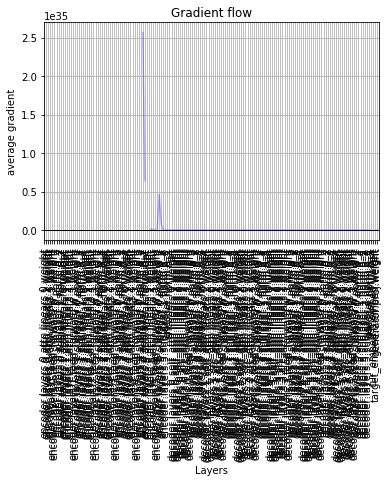

In [91]:
print("Initialising and creating models....")
t1=time.time()
criterion=LabelSmoothing()
model=make_model(voc.num_words,voc.num_words)
model_opt=torch.optim.Adam(model.parameters(),lr=0.0001,betas=(0.9,0.988),eps=1e-9)
print("="*100)
print("Creating Models took: "+str(time.time()-t1))



model.train()
for epoch in range(10):
    
    current_batch=batches[epoch]
    loss_val=run_epoch(current_batch,model,LossCompute(model,criterion,model_opt))
    print("Epoch: "+str(epoch)+"Loss Value: "+str(loss_val))
    
    